In [70]:
%matplotlib inline
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot
import warnings

In [7]:
from statsmodels.graphics.api import qqplot

In [20]:
def parser(time):
    return datetime.datetime.fromtimestamp(float(time)/1000)
datah = pd.read_csv('data/[1h]BTCUSDT.csv', parse_dates=['Start', 'Stop'], date_parser=parser)

datah.head()

,Start,Stop,Open,Close,Low,High,Volume
0,2017-08-17 07:00:00,2017-08-17 07:59:59.999,4261.48,4308.83,4261.32,4313.62,47.181009
1,2017-08-17 08:00:00,2017-08-17 08:59:59.999,4308.83,4315.32,4291.37,4328.69,23.234916
2,2017-08-17 09:00:00,2017-08-17 09:59:59.999,4330.29,4324.35,4309.37,4345.45,7.229691
3,2017-08-17 10:00:00,2017-08-17 10:59:59.999,4316.62,4349.99,4287.41,4349.99,4.443249
4,2017-08-17 11:00:00,2017-08-17 11:59:59.999,4333.32,4360.69,4333.32,4377.85,0.972807


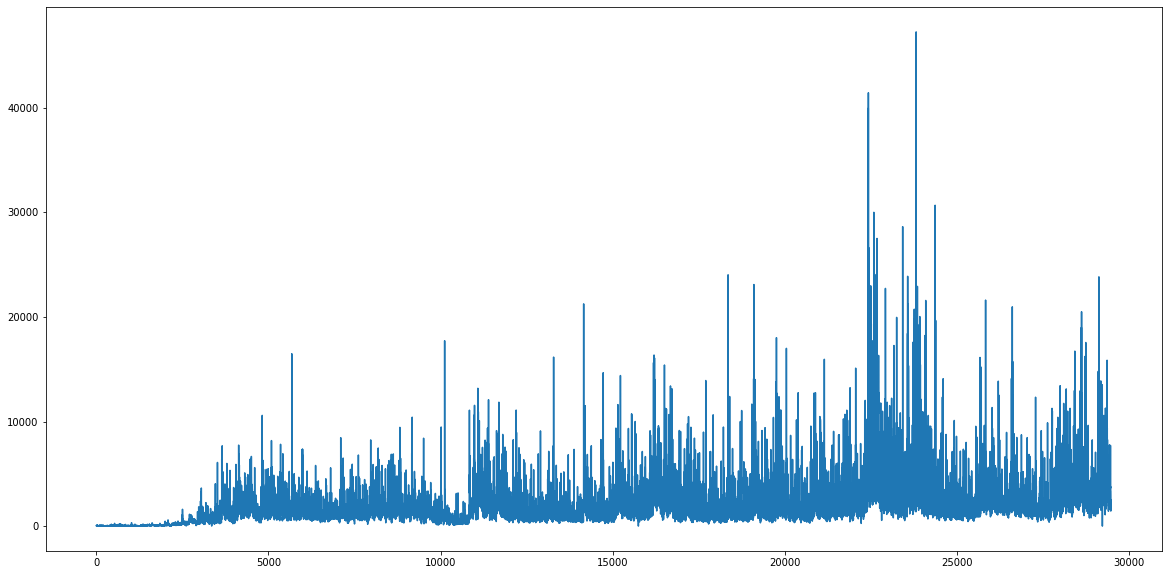

In [49]:
plt.figure(figsize=(20,10))
plt.plot(datah.Volume)

<AxesSubplot:xlabel='Stop'>

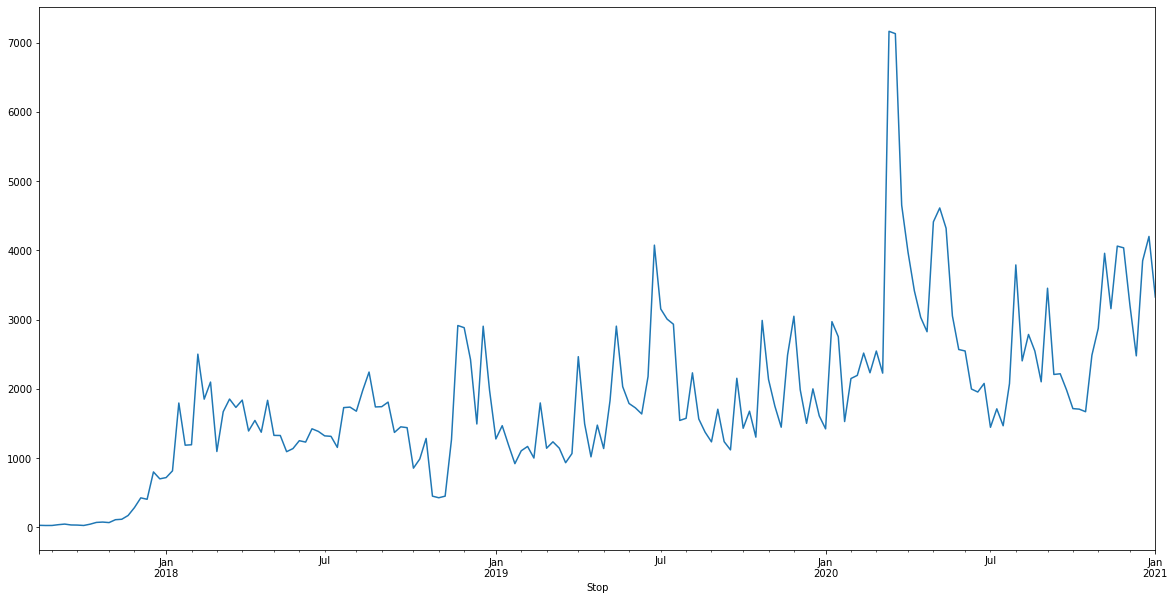

In [65]:
y=dataset.copy().set_index('Stop').Volume.resample("W").mean()
y.plot(figsize=(20, 10))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


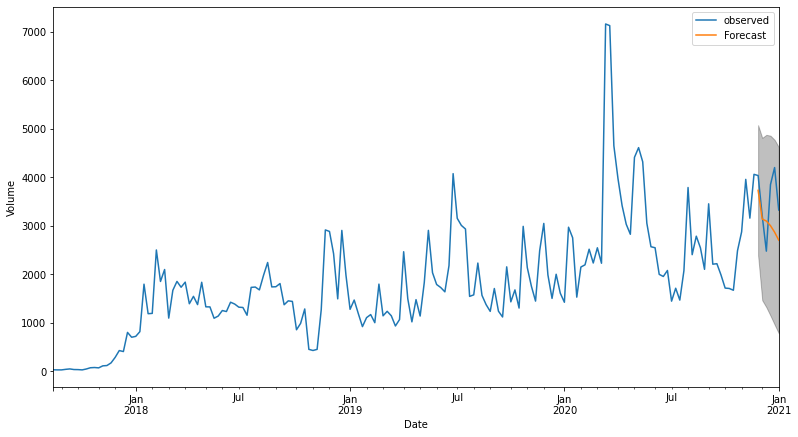

In [76]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    model = ARIMA(y[:171], order=(2, 0, 8))
    yhat_1 =  model.fit().predict(len(y[:171]), len(y[:171])+5)
pred_uc = model.fit().get_forecast(steps=6)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(13, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Volume')
plt.legend()
plt.show()